### Import data

In [1]:
import pickle
import numpy as np

def read_data(filename):
    x = pickle._Unpickler(open(filename, 'rb'))
    x.encoding = 'latin1'
    data = x.load()
    return data

files = []
for n in range(1, 33):
    s = ''
    if n < 10:
        s += '0'
    s += str(n)
    files.append(s)

labels = []
data = []
for i in files:
    filepath = "archive/data_preprocessed_python/s" + i + ".dat"
    d = read_data(filepath)
    labels.append(d['labels'])
    data.append(d['data'])



#### Reshape data and select EEG channels

In [2]:

labels = np.array(labels).reshape(1280, 4)
data = np.array(data).reshape(1280, 40, 8064)
eeg_data = data[:,:32,:] # Select the 32 EEG channels
print(eeg_data.shape)
print(labels.shape)


(1280, 32, 8064)
(1280, 4)


#### Visualize data

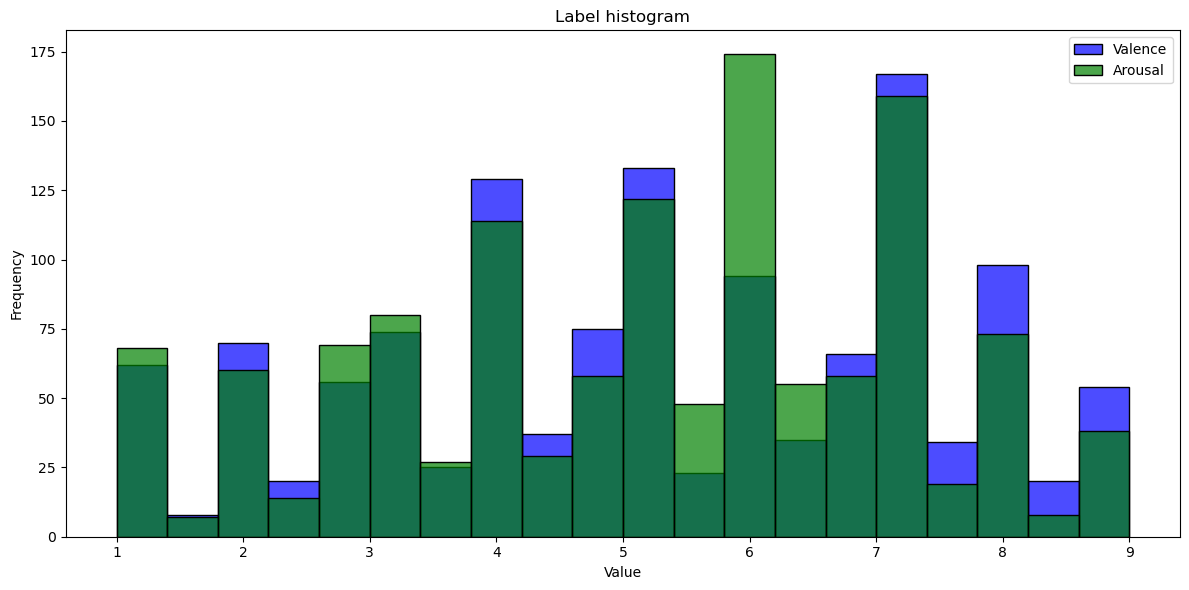

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot overlapping histograms for the first and second columns of labels
plt.figure(figsize=(12, 6))

sns.histplot(labels[:, 0], bins=20, color='blue', alpha=0.7, label='Valence')
sns.histplot(labels[:, 1], bins=20, color='green', alpha=0.7, label='Arousal')

plt.title('Label histogram')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()


#### Compute Power Spectral Density of brain signals for each brain wave band

In [4]:
from scipy.signal import welch
from scipy.integrate import simps

def bandpower(data, sf, band):
    band = np.asarray(band)
    low, high = band
    nperseg = int((2 / low) * sf)
    freqs, psd = welch(data, sf, nperseg=nperseg)
    freq_res = freqs[1] - freqs[0]
    idx_band = np.logical_and(freqs >= low, freqs <= high)
    bp = simps(psd[idx_band], dx=freq_res)
    return bp

def get_band_power(data, sf, channel, band):
    bands = {
        "delta": (0.5, 4),
        "theta": (4, 8),
        "alpha": (8, 12),
        "beta": (12, 30),
        "gamma": (30, 64)
    }
    return bandpower(data[channel], sf, bands[band])

sf = 128  # Sampling frequency
bands = ["delta", "theta", "alpha", "beta", "gamma"]

eeg_band = np.zeros((eeg_data.shape[0], eeg_data.shape[1] * len(bands)))

for i in range(eeg_data.shape[0]):
    for j in range(eeg_data.shape[1]):
        for k, band in enumerate(bands):
            eeg_band[i, j * len(bands) + k] = get_band_power(eeg_data[i], sf, j, band)

print(eeg_band.shape)


(1280, 160)


In [5]:
import pandas as pd
pd.DataFrame(eeg_band).head(10)

,0,1,2,3,4,5,6,7,8,9,...,150,151,152,153,154,155,156,157,158,159
0,0.030791,3.966387,3.362791,5.815234,1.216603,0.067184,5.102688,3.944452,6.646149,1.261336,...,0.091025,6.766592,6.189954,7.055265,1.177492,0.065847,5.434120,5.369596,6.286556,0.987916
1,0.086600,5.171664,4.159797,6.395374,1.450174,0.134854,7.009709,4.826470,7.266016,1.318514,...,0.221600,10.031310,7.715087,7.725304,1.253575,0.110520,7.958460,6.850178,6.795912,1.152470
2,0.057484,4.839268,4.294426,6.721424,1.541999,0.089844,6.321618,5.004187,8.149888,1.660937,...,0.137920,9.238961,9.179372,9.283133,1.479029,0.073230,6.864887,8.209320,8.429777,1.410791
3,0.053079,4.442888,3.519818,5.380133,1.280744,0.059321,6.709155,4.250171,6.090829,1.208452,...,0.086876,8.802466,6.922430,6.950315,1.132223,0.050054,6.850906,6.541218,6.753938,1.026295
4,0.038066,2.698928,2.770151,4.911636,1.076200,0.054365,3.034321,2.933423,5.472712,1.120326,...,0.050368,3.678479,5.225959,6.270482,1.036078,0.058468,3.681268,5.195625,6.161676,0.946582
5,0.051739,4.024860,3.535367,5.426490,1.357932,0.082481,4.900829,3.852156,6.035693,1.174744,...,0.106770,7.521480,7.106088,7.050821,1.291767,0.070789,6.610349,6.224046,6.247701,1.124890
6,0.072726,4.524433,4.117581,5.698607,1.241507,0.095898,6.056792,4.746292,7.080272,1.584222,...,0.173744,9.016845,8.124075,8.281151,1.269174,0.084738,5.524867,6.822795,7.488367,1.131017
7,0.053950,6.224641,5.034346,6.856175,1.567620,0.080708,8.286740,6.205477,8.272224,1.442914,...,0.130589,10.325636,10.840115,9.648808,1.569249,0.077480,8.362805,10.041464,9.171436,1.721038
8,0.052016,6.404616,5.135986,7.506420,1.755587,0.095538,9.482683,6.235595,8.842913,1.499615,...,0.184748,13.525893,9.954437,9.419640,1.598435,0.066551,9.477365,8.160465,8.362228,1.474454
9,0.060121,4.157208,4.034130,6.073305,1.330574,0.083487,5.091712,4.395577,7.080776,1.307593,...,0.098387,7.202638,7.129745,8.121126,1.566362,0.044774,5.193759,6.046838,7.244295,1.712771


#### Encode labels

In [46]:
label_name = ["valence","arousal"]
labels_valence = []
labels_arousal = []

#9 classes
#labels_valence = ["LOW" if la[0] < 3 else "MEDIUM" if la[0] < 6 else "HIGH" for la in labels] 
#labels_arousal = ["LOW" if la[1] < 3 else "MEDIUM" if la[1] < 6 else "HIGH" for la in labels]

#4 classes
labels_valence = ["LOW" if (lab[0]-1)/8 < 0.4 else "HIGH" for lab in labels]
labels_arousal = ["LOW" if (lab[1]-1)/8 < 0.4 else "HIGH" for lab in labels]

combined_labels = np.array([labels_valence[i] + '_' + labels_arousal[i] for i in range(len(labels_valence))]).reshape(-1,1)


from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder()
enc.fit(combined_labels)
enc.categories_
yData_enc = enc.transform(combined_labels).reshape(-1)

num_categories = len(np.unique(yData_enc))
num_categories

4

In [47]:
pd.DataFrame({'Valence': np.array(labels_valence).reshape(-1), 'Arousal': np.array(labels_arousal).reshape(-1),'combined_labels': combined_labels.reshape(-1), 'yData_enc': yData_enc.reshape(-1)}).head(10)

,Valence,Arousal,combined_labels,yData_enc
0,HIGH,HIGH,HIGH_HIGH,0.0
1,HIGH,HIGH,HIGH_HIGH,0.0
2,HIGH,HIGH,HIGH_HIGH,0.0
3,HIGH,HIGH,HIGH_HIGH,0.0
4,HIGH,LOW,HIGH_LOW,1.0
5,HIGH,LOW,HIGH_LOW,1.0
6,HIGH,LOW,HIGH_LOW,1.0
7,HIGH,LOW,HIGH_LOW,1.0
8,LOW,LOW,LOW_LOW,3.0
9,LOW,HIGH,LOW_HIGH,2.0


#### Extract polynomial features and select the ones that explain variance (PCA) - Include this in the report ? - Generate xData1

In [48]:
from sklearn.decomposition import PCA
from sklearn import preprocessing

xData_eeg_band = eeg_band

poly = preprocessing.PolynomialFeatures(degree=2)
pca = PCA(n_components=500)

xData_eeg_band = poly.fit_transform(xData_eeg_band)
xData_eeg_band=pca.fit_transform(xData_eeg_band)

xData_eeg_band = preprocessing.scale(xData_eeg_band)
xData_eeg_band.shape

c:\Users\josebencao9\miniconda3\envs\faip\lib\site-packages\sklearn\preprocessing\_data.py:247: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(


(1280, 500)

#### K-nearest neighbors classifier

n_neighbors: 1, train_score: 1.0000, test_score: 0.3477
n_neighbors: 2, train_score: 0.7070, test_score: 0.4102
n_neighbors: 3, train_score: 0.6191, test_score: 0.4102
n_neighbors: 4, train_score: 0.5859, test_score: 0.4336
n_neighbors: 5, train_score: 0.5713, test_score: 0.3789
n_neighbors: 6, train_score: 0.5625, test_score: 0.4062
n_neighbors: 7, train_score: 0.5625, test_score: 0.3945
n_neighbors: 8, train_score: 0.5352, test_score: 0.4297
n_neighbors: 9, train_score: 0.5234, test_score: 0.4023
n_neighbors: 10, train_score: 0.5166, test_score: 0.4102
n_neighbors: 11, train_score: 0.5166, test_score: 0.4062
n_neighbors: 12, train_score: 0.5000, test_score: 0.4180
n_neighbors: 13, train_score: 0.4980, test_score: 0.4336
n_neighbors: 14, train_score: 0.4912, test_score: 0.4297
n_neighbors: 15, train_score: 0.4971, test_score: 0.4180
n_neighbors: 16, train_score: 0.4912, test_score: 0.4375
n_neighbors: 17, train_score: 0.4795, test_score: 0.4219
n_neighbors: 18, train_score: 0.4746, te

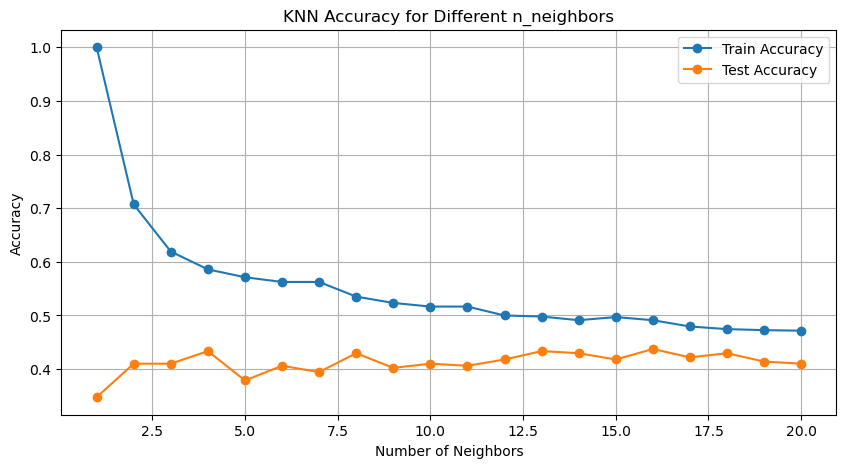

In [49]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(xData_eeg_band, yData_enc, test_size=0.2, random_state=42)

# Loop over different values of n_neighbors
neighbors = range(1, 21)
train_scores = []
test_scores = []

for n in neighbors:
    modelKNN = KNeighborsClassifier(n_neighbors=n)
    modelKNN.fit(X_train, y_train)
    
    train_score = modelKNN.score(X_train, y_train)
    test_score = modelKNN.score(X_test, y_test)
    
    train_scores.append(train_score)
    test_scores.append(test_score)
    
    print(f"n_neighbors: {n}, train_score: {train_score:.4f}, test_score: {test_score:.4f}")

print("Best number of neighbors: ",neighbors[np.argmax(test_scores)])

# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(neighbors, train_scores, label='Train Accuracy', marker='o')
plt.plot(neighbors, test_scores, label='Test Accuracy', marker='o')
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.title('KNN Accuracy for Different n_neighbors')
plt.legend()
plt.grid(True)
plt.show()


test_score = {}


modelKNN = KNeighborsClassifier(n_neighbors = neighbors[np.argmax(test_scores)])
modelKNN.fit(X_train, y_train)
test_score['KNN'] = modelKNN.score(X_test, y_test)
    

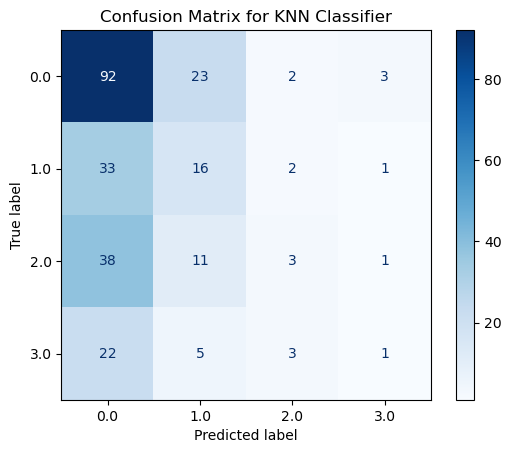

              precision    recall  f1-score   support

   HIGH_HIGH       0.50      0.77      0.60       120
    HIGH_LOW       0.29      0.31      0.30        52
    LOW_HIGH       0.30      0.06      0.10        53
     LOW_LOW       0.17      0.03      0.05        31

    accuracy                           0.44       256
   macro avg       0.31      0.29      0.26       256
weighted avg       0.37      0.44      0.37       256



In [50]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

# Predict the labels for the test set
y_pred = modelKNN.predict(X_test)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for KNN Classifier')
plt.show()

# Generate a classification report
report = classification_report(y_test, y_pred, target_names=enc.categories_[0])
print(report)

#### Define Neural Netwrok models

In [51]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
import torch.nn.functional as F

# Define the neural network model
class LinearNeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(LinearNeuralNet, self).__init__()
        # First fully connected layer
        self.fc1 = nn.Linear(input_size, hidden_size)
        # Second fully connected layer
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        # Third fully connected layer
        self.fc3 = nn.Linear(hidden_size, hidden_size)

        self.fc4 = nn.Linear(hidden_size, hidden_size)
        self.fc5 = nn.Linear(hidden_size, hidden_size)

        # Output layer
        self.fcFinal = nn.Linear(hidden_size, num_classes)

        # Activations, Dropout, and Batch Normalization
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.3)  # Dropout with 30% probability
        self.batchnorm1 = nn.BatchNorm1d(hidden_size)
        self.batchnorm2 = nn.BatchNorm1d(hidden_size)

    def forward(self, x):
        # Forward pass with batch normalization and dropout
        out = self.fc1(x)
        out = self.batchnorm1(out)
        out = self.relu(out)
        out = self.dropout(out)

        out = self.fc2(out)
        out = self.batchnorm2(out)
        out = self.relu(out)
        out = self.dropout(out)

        out = self.fc3(out)
        out = self.batchnorm2(out)
        out = self.relu(out)
        out = self.dropout(out)

        out = self.fc4(out)
        out = self.batchnorm2(out)
        out = self.relu(out)
        out = self.dropout(out)


        out = self.fc5(out)
        out = self.relu(out)

        out = self.fcFinal(out)
        return out
    


    import torch


class ConvNeuralNet(nn.Module):
    def __init__(self, num_classes):
        super(ConvNeuralNet, self).__init__()
        
        # First convolutional layer
        self.conv1 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=7, stride=1, padding=3)
        self.bn1 = nn.BatchNorm1d(64)
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2)
        
        # Second convolutional layer
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=5, stride=1, padding=2)
        self.bn2 = nn.BatchNorm1d(128)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)
        
        # Third convolutional layer
        self.conv3 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm1d(256)
        self.pool3 = nn.MaxPool1d(kernel_size=2, stride=2)
        
        # Fully connected layers
        self.fc1 = nn.Linear(256 * (8064 // 8), 512)  # Adjust to account for pooling
        self.fc2 = nn.Linear(512, 256)  # New hidden layer
        self.dropout = nn.Dropout(0.5)
        self.fc3 = nn.Linear(256, num_classes)  # Output layer
        
    def forward(self, x):
        x = self.pool1(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool2(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool3(torch.relu(self.bn3(self.conv3(x))))
        
        # Flatten for fully connected layers
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))  # New hidden layer activation
        x = self.fc3(x)
        
        return x


class EEGNet(nn.Module):
    def __init__(self, num_channels=32, num_samples=8064, num_classes=9, dropout_rate=0.5):
        super(EEGNet, self).__init__()
        
        # First block: Temporal Convolution
        self.temporal_conv = nn.Conv2d(1, 8, (1, 64), padding=(0, 32), bias=False)
        self.batchnorm1 = nn.BatchNorm2d(8)
        
        # Second block: Depthwise Convolution
        self.depthwise_conv = nn.Conv2d(8, 16, (num_channels, 1), groups=8, bias=False)
        self.batchnorm2 = nn.BatchNorm2d(16)
        self.activation = nn.ELU()
        self.avgpool1 = nn.AvgPool2d((1, 4))
        self.dropout1 = nn.Dropout(dropout_rate)
        
        # Third block: Separable Convolutions
        self.separable_conv1 = nn.Conv2d(16, 16, (1, 16), padding=(0, 8), bias=False)
        self.batchnorm3 = nn.BatchNorm2d(16)
        self.separable_conv2 = nn.Conv2d(16, 16, (1, 1), bias=False)
        self.batchnorm4 = nn.BatchNorm2d(16)
        self.avgpool2 = nn.AvgPool2d((1, 8))
        self.dropout2 = nn.Dropout(dropout_rate)
        
        # Final Fully Connected Layer
        self.fc = nn.Linear(16 * (num_samples // (4 * 8)), num_classes)
    
    def forward(self, x):
        # Temporal Convolution
        x = self.temporal_conv(x)
        x = self.batchnorm1(x)
        x = x ** 2  # Squaring non-linearity
        
        # Depthwise Convolution
        x = self.depthwise_conv(x)
        x = self.batchnorm2(x)
        x = self.activation(x)
        x = self.avgpool1(x)
        x = self.dropout1(x)
        
        # Separable Convolutions
        x = self.separable_conv1(x)
        x = self.batchnorm3(x)
        x = self.separable_conv2(x)
        x = self.batchnorm4(x)
        x = self.activation(x)
        x = self.avgpool2(x)
        x = self.dropout2(x)
        
        # Flatten for Fully Connected layer
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        
        return x


# Function to calculate accuracy
def calculate_accuracy(outputs, targets):
    _, predicted = torch.max(outputs, 1)  # Get index of the max log-probability
    correct = (predicted == targets).sum().item()
    accuracy = correct / targets.size(0)
    return accuracy


In [52]:
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import StepLR

batch_size = 64
learning_rate = 0.01
hidden_size = 128

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')



In [53]:
num_epochs = 100
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(xData_eeg_band, yData_enc, test_size=0.2, random_state=42)

# Create DataLoader for training and validation sets
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.long))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Linear Neural Network
model_linear = LinearNeuralNet(input_size=500, hidden_size=128, num_classes=num_categories).to(device)
optimizer_linear = optim.Adam(model_linear.parameters(), lr=learning_rate)
scheduler_linear = StepLR(optimizer_linear, step_size=5, gamma=0.1)
criterion = nn.CrossEntropyLoss()

print("Training LinearNN...")
for epoch in range(num_epochs):
    model_linear.train()
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        outputs = model_linear(batch_X)
        loss = criterion(outputs, batch_y)
        optimizer_linear.zero_grad()
        loss.backward()
        optimizer_linear.step()
    scheduler_linear.step()
    model_linear.eval()
    val_loss = 0
    val_accuracy = 0
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model_linear(batch_X)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item()
            val_accuracy += calculate_accuracy(outputs, batch_y)
    val_loss /= len(val_loader)
    val_accuracy /= len(val_loader)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}, Learning Rate: {scheduler_linear.get_last_lr()[0]:.6f}')
print("Finished training LinearNN.\n")
test_score["LinearNN"] = val_accuracy


Training LinearNN...
Epoch [1/100], Loss: 1.3377, Val Loss: 1.3274, Val Accuracy: 0.4688, Learning Rate: 0.010000
Epoch [2/100], Loss: 1.2925, Val Loss: 1.2980, Val Accuracy: 0.4688, Learning Rate: 0.010000
Epoch [3/100], Loss: 1.3333, Val Loss: 1.3823, Val Accuracy: 0.2500, Learning Rate: 0.010000
Epoch [4/100], Loss: 1.4261, Val Loss: 1.4488, Val Accuracy: 0.3320, Learning Rate: 0.010000
Epoch [5/100], Loss: 1.4796, Val Loss: 1.5290, Val Accuracy: 0.3555, Learning Rate: 0.001000
Epoch [6/100], Loss: 1.4228, Val Loss: 1.4636, Val Accuracy: 0.3633, Learning Rate: 0.001000
Epoch [7/100], Loss: 1.5048, Val Loss: 1.5372, Val Accuracy: 0.3633, Learning Rate: 0.001000
Epoch [8/100], Loss: 1.4845, Val Loss: 1.5262, Val Accuracy: 0.3672, Learning Rate: 0.001000
Epoch [9/100], Loss: 1.5040, Val Loss: 1.5577, Val Accuracy: 0.3789, Learning Rate: 0.001000
Epoch [10/100], Loss: 1.4792, Val Loss: 1.5191, Val Accuracy: 0.3672, Learning Rate: 0.000100
Epoch [11/100], Loss: 1.5160, Val Loss: 1.5629, 

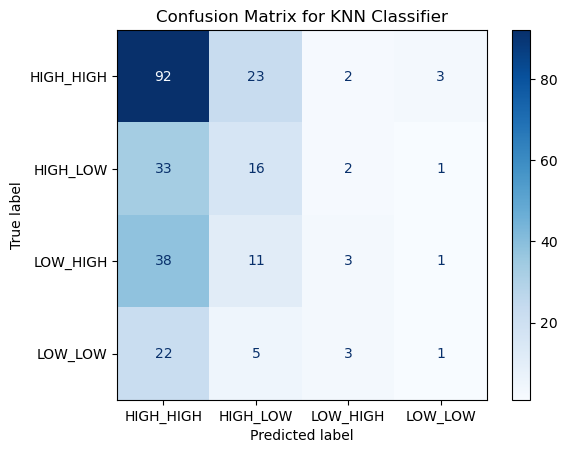

In [54]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict the labels for the test set
y_pred = modelKNN.predict(X_test)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=enc.categories_[0])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for KNN Classifier')
plt.show()

In [29]:
num_epochs = 50
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(eeg_data, yData_enc, test_size=0.2, random_state=42)

# Create DataLoader for training and validation sets
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.long))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Conv Neural Network
model_conv = ConvNeuralNet(4).to(device)
optimizer_conv = optim.Adam(model_conv.parameters(), lr=learning_rate)
scheduler_conv = StepLR(optimizer_conv, step_size=5, gamma=0.1)

print("Training ConvNN...")
best_val_accuracy = 0
patience = 5
trigger_times = 0

for epoch in range(num_epochs):
    model_conv.train()
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        outputs = model_conv(batch_X)
        loss = criterion(outputs, batch_y)
        optimizer_conv.zero_grad()
        loss.backward()
        optimizer_conv.step()
    scheduler_conv.step()
    model_conv.eval()
    val_loss = 0
    val_accuracy = 0
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model_conv(batch_X)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item()
            val_accuracy += calculate_accuracy(outputs, batch_y)
    val_loss /= len(val_loader)
    val_accuracy /= len(val_loader)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}, Learning Rate: {scheduler_conv.get_last_lr()[0]:.6f}')
    
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        trigger_times = 0
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print("Early stopping due to no improvement in validation accuracy.")
            break

print("Finished training ConvNN.\n")
test_score["ConvNN"] = val_accuracy


Training ConvNN...
Epoch [1/50], Loss: 1.3875, Val Loss: 1.4206, Val Accuracy: 0.1562, Learning Rate: 0.010000
Epoch [2/50], Loss: 1.3762, Val Loss: 1.3756, Val Accuracy: 0.4414, Learning Rate: 0.010000
Epoch [3/50], Loss: 1.3572, Val Loss: 1.3524, Val Accuracy: 0.4414, Learning Rate: 0.010000
Epoch [4/50], Loss: 1.3429, Val Loss: 1.3332, Val Accuracy: 0.4414, Learning Rate: 0.010000
Epoch [5/50], Loss: 1.3335, Val Loss: 1.3184, Val Accuracy: 0.4414, Learning Rate: 0.001000
Epoch [6/50], Loss: 1.3328, Val Loss: 1.3173, Val Accuracy: 0.4414, Learning Rate: 0.001000
Epoch [7/50], Loss: 1.3322, Val Loss: 1.3163, Val Accuracy: 0.4414, Learning Rate: 0.001000
Early stopping due to no improvement in validation accuracy.
Finished training ConvNN.



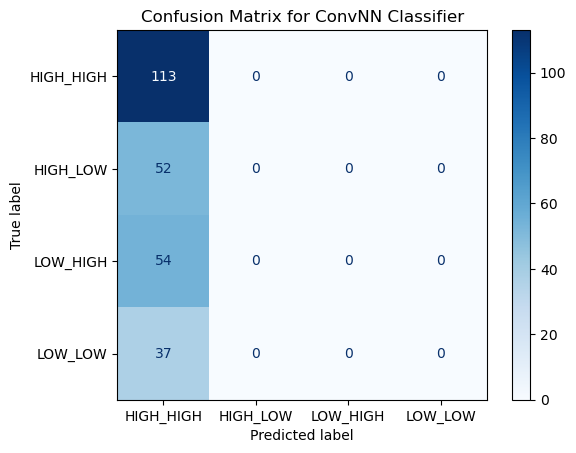

In [30]:
# ConvNN Confusion Matrix
model_conv.eval()
y_pred_conv = []
with torch.no_grad():
    for batch_X, batch_y in val_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        outputs = model_conv(batch_X)
        _, predicted = torch.max(outputs, 1)
        y_pred_conv.extend(predicted.cpu().numpy())

cm_conv = confusion_matrix(y_val, y_pred_conv)
disp_conv = ConfusionMatrixDisplay(confusion_matrix=cm_conv, display_labels=enc.categories_[0])
disp_conv.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for ConvNN Classifier')
plt.show()


In [31]:
# EEGNet
model_eegnet = EEGNet(32, 8064, 4, 0.5).to(device)
optimizer_eegnet = optim.AdamW(model_eegnet.parameters(), lr=learning_rate)
scheduler_eegnet = StepLR(optimizer_eegnet, step_size=5, gamma=0.1)

print("Training EEGNet...")
best_val_accuracy = 0
patience = 5
trigger_times = 0

for epoch in range(num_epochs):
    model_eegnet.train()
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        # Adjust input shape for EEGNet
        batch_X = batch_X.unsqueeze(1)  # Add channel dimension
        outputs = model_eegnet(batch_X)
        loss = criterion(outputs, batch_y)
        optimizer_eegnet.zero_grad()
        loss.backward()
        optimizer_eegnet.step()
    scheduler_eegnet.step()
    model_eegnet.eval()
    val_loss = 0
    val_accuracy = 0
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            batch_X = batch_X.unsqueeze(1)  # Add channel dimension
            outputs = model_eegnet(batch_X)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item()
            val_accuracy += calculate_accuracy(outputs, batch_y)
    val_loss /= len(val_loader)
    val_accuracy /= len(val_loader)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}, Learning Rate: {scheduler_eegnet.get_last_lr()[0]:.6f}')
    
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        trigger_times = 0
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print("Early stopping due to no improvement in validation accuracy.")
            break

print("Finished training EEGNet.\n")
test_score["EEGNet"] = val_accuracy

# Save the models
torch.save(model_linear.state_dict(), 'LinearNN_model.pth')
torch.save(model_conv.state_dict(), 'ConvNN_model.pth')
torch.save(model_eegnet.state_dict(), 'EEGNet_model.pth')

Training EEGNet...
Epoch [1/50], Loss: 2.5615, Val Loss: 2.7253, Val Accuracy: 0.3086, Learning Rate: 0.010000
Epoch [2/50], Loss: 1.6149, Val Loss: 1.7534, Val Accuracy: 0.4102, Learning Rate: 0.010000
Epoch [3/50], Loss: 1.6214, Val Loss: 1.7205, Val Accuracy: 0.4141, Learning Rate: 0.010000
Epoch [4/50], Loss: 1.6705, Val Loss: 1.6882, Val Accuracy: 0.4180, Learning Rate: 0.010000
Epoch [5/50], Loss: 1.5906, Val Loss: 1.6872, Val Accuracy: 0.4297, Learning Rate: 0.001000
Epoch [6/50], Loss: 1.5520, Val Loss: 1.6716, Val Accuracy: 0.4297, Learning Rate: 0.001000
Epoch [7/50], Loss: 1.5195, Val Loss: 1.6952, Val Accuracy: 0.4258, Learning Rate: 0.001000
Epoch [8/50], Loss: 1.5090, Val Loss: 1.7113, Val Accuracy: 0.4180, Learning Rate: 0.001000
Epoch [9/50], Loss: 1.5111, Val Loss: 1.7357, Val Accuracy: 0.4023, Learning Rate: 0.001000
Epoch [10/50], Loss: 1.5018, Val Loss: 1.7095, Val Accuracy: 0.4180, Learning Rate: 0.000100
Early stopping due to no improvement in validation accuracy.

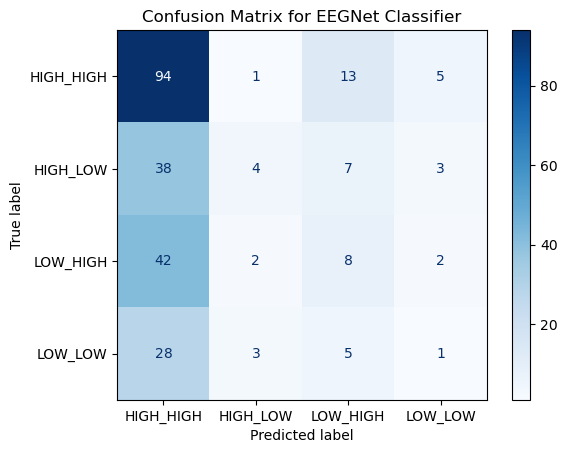

In [34]:

# EEGNet Confusion Matrix
model_eegnet.eval()
y_pred_eegnet = []
with torch.no_grad():
    for batch_X, batch_y in val_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        batch_X = batch_X.unsqueeze(1)  # Add channel dimension
        outputs = model_eegnet(batch_X)
        _, predicted = torch.max(outputs, 1)
        y_pred_eegnet.extend(predicted.cpu().numpy())

cm_eegnet = confusion_matrix(y_val, y_pred_eegnet)
disp_eegnet = ConfusionMatrixDisplay(confusion_matrix=cm_eegnet, display_labels=enc.categories_[0])
disp_eegnet.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for EEGNet Classifier')
plt.show()

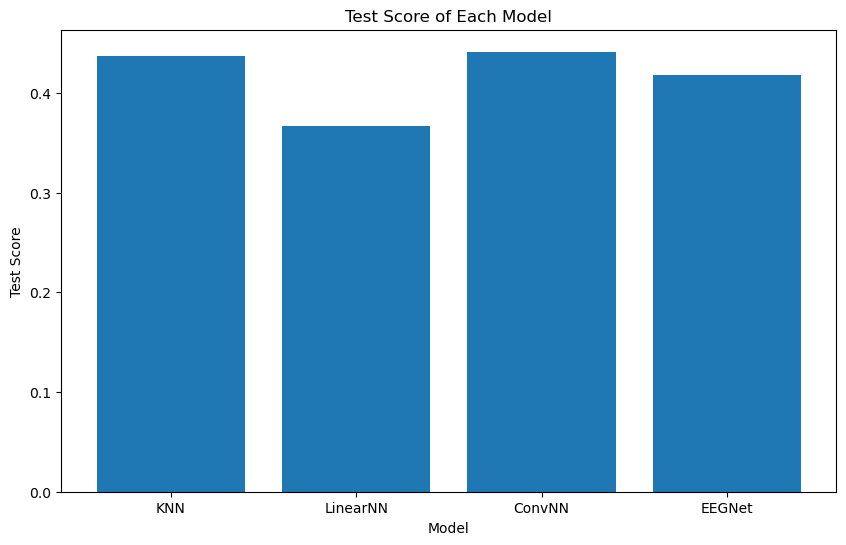

In [35]:
import matplotlib.pyplot as plt

# Extract model names and their corresponding test scores
model_names = list(test_score.keys())
scores = list(test_score.values())

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(model_names, scores)

# Add title and labels
plt.title('Test Score of Each Model')
plt.xlabel('Model')
plt.ylabel('Test Score')

# Show the plot
plt.show()